In [ ]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from random import sample
from scipy.stats import ortho_group
from google.colab import drive
import pickle
import sys
import pandas as pd
import gc
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples
import random
from itertools import product 
from itertools import chain
import itertools
import numpy as np
import math
import os 

In [ ]:
############## functions for rff, including clustering
def row_noramlize(an_array,if_l2):
  if if_l2 == 1:
    sum_of_rows = np.linalg.norm(an_array,axis=1)
  else:
    sum_of_rows = np.max(np.abs(an_array),axis=1)
  normalized_array = an_array / sum_of_rows[:, np.newaxis]
  return normalized_array

def Cluster_Computation(emb, k):
    
    '''
    Do the k means for the embedding, and output labels and centroids
    '''
    scaler= StandardScaler()
    std = scaler.fit_transform(emb)
    #std = emb
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k,tol=0.00001,max_iter=30000)

    #std=emb ##already normalized, so no need to standardize
    labels_sample = km.fit_predict(std)
    centroids = km.cluster_centers_
    centroids = scaler.inverse_transform(centroids)
    
    #label each sample based on clusters
    labels_list = list(range(k))
    
    return {'labels_sample':labels_sample, 'centroids':centroids,'labels_list':labels_list} 


def generate_real_number(x,y):
  '''
  Given number x_k y_k, generate alpha_k and beta_k, assuming they are real, to minimize the l2 norm
  '''
  if x==0:
    return 10000000000000000
  else:
    return (math.sqrt(abs(y/x)))

def generate_matrix_A_real(x,y):
    '''
    Given vector x,y, generate the matrix A such that the estimator such that variance is minimized, based on generate_real_number
    '''    
    return np.diag([generate_real_number(a,b) for a,b in zip(x,y)])

## Do the cluster for queries and keys, return the list of matrices, that's what we need, also output a list of matries to indicate the cluster
def generate_matrix_using_cluaster(Q,K,k=2): #k is the number of clusters
    cluster_result_queries = Cluster_Computation(Q,k)
    cluster_result_keys = Cluster_Computation(K,k)

    queries_centroids_list = dict(zip(cluster_result_queries['labels_list'], cluster_result_queries['centroids']))
    keys_centroids_list = dict(zip(cluster_result_keys['labels_list'], cluster_result_keys['centroids']))

    ## Compute matrix A for every pairs of centroids of queries and keys
    list_of_matrix_A_real = {}
    list_of_matrix_A_complex = {}

 
    cluster_matrix_indicator = []  ## record if the point (q,k) is in (i,j)-th cluster
    for i in range(k):
      for j in range(k):
 
        queries_cluster_i = np.array([1 if value == i else 0 for value in cluster_result_queries['labels_sample']])
        keys_cluster_j = np.array([1 if value == j else 0 for value in cluster_result_keys['labels_sample']])

        cluster_matrix_indicator.append(np.outer(queries_cluster_i, keys_cluster_j))

    for x, y in product(queries_centroids_list, keys_centroids_list):
        list_of_matrix_A_real.update({(x, y): generate_matrix_A_real(queries_centroids_list[x], keys_centroids_list[y])})
 
    return {'list_of_matrix_A_real':list_of_matrix_A_real,'cluster_matrix_indicator':cluster_matrix_indicator}

  

# random feature map
def phi(h, fs, random_feats, m):
    return lambda x: (
        h(x)
        / np.sqrt(m)
        * np.concatenate(
            [f(np.einsum("...d,md->...m", x, random_feats)) for f in fs],
            axis=-1,
        )
    )

def att_hat(q, k, phi, normalize_input=True, normalize_output=False):
    l, d = k.shape
  
    normalizer = 1 / (d ** 0.25) if normalize_input else 1
    q_prime = phi(q * normalizer)
   
    k_prime = phi(k * normalizer)

    if normalize_output:

      d_inv = np.diag(1 / (q_prime @ (k_prime.T @ np.ones(l))))
      return d_inv @ (q_prime @ k_prime.T)

    else:
      return q_prime @ k_prime.T    

### function for FAVOR+
def positive_att_hat(q, k, random_feats, normalize_input=False, normalize_output=False):
    def h(x):
        return np.exp(-np.square(x).sum(axis=-1, keepdims=True) / 2)

    kernel = phi(h, [np.exp], random_feats, random_feats.shape[0])
 
    return att_hat(q, k, kernel, normalize_input = normalize_input,   normalize_output = normalize_output)
    

### transform vector x and y such that sign(x) == - sign(y) to yield variance 0, keep the first k unchanged
def transform_sign(x,y,k=0):
  sign_x = np.sign(x)
  sign_x = np.append(-(np.sign(y))[:k],(sign_x)[-(len(y)-k):])
  y_temp = np.multiply(np.abs(y),-sign_x)

  return x,y_temp
 
## complex epx estimator
def soft_max_A(x, y, A, A_inv, Gauss_random_vector):
   
    random_feats_sfm = Gauss_random_vector.shape[0]
    # need abs here to compute the norm
    phi_A_x = 1/math.sqrt(random_feats_sfm) * np.exp(- (np.sum(np.abs(A@x) ** 2, axis = 0)) /2 ) * np.exp([(w.T)@A@x for w in Gauss_random_vector])
    phi_A_y = 1/math.sqrt(random_feats_sfm) * np.exp(- (np.sum(np.abs(A_inv@y) ** 2, axis = 0)) /2 ) * np.exp([(w.T)@A_inv@y for w in Gauss_random_vector])
 
    return phi_A_x.T@phi_A_y

 

#### hybrid est
def soft_max_A_hybrid(x, y, A, A_inv, tau, Gauss_random_vector):
    random_feats_sfm = Gauss_random_vector.shape[0]

    Gauss_random_vector = [item/tau for item in Gauss_random_vector] ## divide all values by tau
    
    # need abs here to compute the norm
    phi_A_x = 1/math.sqrt(random_feats_sfm) * np.array(list(chain.from_iterable((np.sin((w.T)@(A@x)), np.cos((w.T)@(A@x))) for w in Gauss_random_vector)))
    phi_A_y = 1/math.sqrt(random_feats_sfm) * np.array(list(chain.from_iterable((np.sin(-(w.T)@(A_inv@y)), np.cos(-(w.T)@(A_inv@y))) for w in Gauss_random_vector)))

    return phi_A_x.T@phi_A_y

#trig est
def trig_rff(x,y, Gauss_random_vector): # input should be real vector
    
    random_feats_sfm = Gauss_random_vector.shape[0]
    #flatten list
    phi_A_x =  1/math.sqrt(random_feats_sfm) * np.exp(np.sum(x** 2, axis = 0)/2)*  np.array(list(chain.from_iterable((np.sin((w.T)@x), np.cos((w.T)@x)) for w in Gauss_random_vector)))
    phi_A_y =  1/math.sqrt(random_feats_sfm) * np.exp(np.sum(y** 2, axis = 0)/2)*  np.array(list(chain.from_iterable((np.sin((w.T)@y), np.cos((w.T)@y)) for w in Gauss_random_vector)))

    return phi_A_x.T@phi_A_y

  
    
def hybrid_A_all(x,y, cluster_result, tau, Gauss_random_vector_softmax, Gauss_random_vector_lambda):

    '''
    Given list of A matrices, find estimator based on each matrix A  x,y dim = (features, #of data)
    '''
    list_of_A = list(cluster_result['list_of_matrix_A_real'].values())
    # # data = col of x, since we are stacking data
    n_data_x = x.shape[1]
    n_data_y = y.shape[1]
    
    list_of_softmax_est = [soft_max_A(x, y, A, np.linalg.inv(A), Gauss_random_vector_softmax) for A in list_of_A] #try to use real for softmax
    list_of_hybrid_est = [soft_max_A_hybrid(x, y, A, np.linalg.inv(A), tau, Gauss_random_vector_lambda) for A in list_of_A]  #try to use real for hybrid
    
    return ({'list_of_softmax_est':list_of_softmax_est,'list_of_hybrid_est':list_of_hybrid_est,'cluster_matrix_indicator':cluster_result['cluster_matrix_indicator']})


#### try to compute the est directly without using vectorization, given inner products and trig_est, softmax_FAVOR_plus as base estimator, if_cluster_matrix=1 means we use 0/1 lambda estimator
def get_softmax_using_raw(result_cluster_sample, if_trig, softmax_FAVOR_plus, softmax_trig, N = 4,if_cluster_matrix = 1):
 
  softmax_matrix_rff_innner_prod = result_cluster_sample['list_of_softmax_est']
  softmax_lambda_matrix_inner_prod =  result_cluster_sample['list_of_hybrid_est']

  cluster_matrix_indicator = result_cluster_sample['cluster_matrix_indicator']

  if if_cluster_matrix ==1:
    softmax_lambda_matrix_inner_prod_sum_remaining = 0 #use cluster matrix, so no base estimator
    softmax_matrix_rff_innner_prod_sum_all = np.sum([np.multiply(x,y) for (x,y) in zip(softmax_matrix_rff_innner_prod,cluster_matrix_indicator)], axis = 0) #sum all estimators based on matries

  else:
    softmax_lambda_matrix_inner_prod_sum_remaining = 1 - np.sum(softmax_lambda_matrix_inner_prod, axis = 0)
    softmax_matrix_rff_innner_prod_sum_all = np.sum([np.multiply(x,y) for (x,y) in zip(softmax_matrix_rff_innner_prod,softmax_lambda_matrix_inner_prod)], axis = 0) #sum all estimators based on matries

 
  if if_trig == 0:
    softmax_matrix_rff_final = softmax_matrix_rff_innner_prod_sum_all + np.multiply(softmax_lambda_matrix_inner_prod_sum_remaining, softmax_FAVOR_plus)
  else:
    softmax_matrix_rff_final = softmax_matrix_rff_innner_prod_sum_all + np.multiply(softmax_lambda_matrix_inner_prod_sum_remaining, softmax_trig)
  
  return softmax_matrix_rff_final


def evaluate_performance(Q, K, cluster_result, data_dim, if_trig,tau_value_list,n_rff,random_number,N=4):
  #this procedure depends on the random number given in the function
  softmax_true = np.exp(Q@(K.T))
  np.random.seed(random_number)
  

  softmax_trig = trig_rff(Q.T,K.T,np.random.normal(size = (n_rff, data_dim)))
  softmax_FAVOR_plus = positive_att_hat(Q, K, np.random.normal(size = (n_rff, data_dim)), normalize_input=False, normalize_output=False) 
 
  mse_trig = np.mean((softmax_trig - softmax_true)**2)
  mse_favor_plus = np.mean((softmax_FAVOR_plus - softmax_true)**2)
 
  
  mse_cluster_list=[]
  for tau_val in tau_value_list: 
      np.random.seed(random_number)
      result_cluster  = hybrid_A_all(x = Q.T, y = K.T, cluster_result=cluster_result,
                                            tau = tau_val,
                                            Gauss_random_vector_softmax = np.random.normal(size = (n_rff, data_dim)), 
                                            Gauss_random_vector_lambda = np.random.normal(size = (1, data_dim))) 
      

      softmax_cluster = get_softmax_using_raw(result_cluster,if_trig,softmax_FAVOR_plus,softmax_trig,N)
      mse_cluster = np.mean((softmax_cluster - softmax_true)**2)

 
      mse_cluster_list.append(mse_cluster)

  return {'dim':data_dim,'mse_trig':mse_trig,'mse_favor_plus':mse_favor_plus,'mse_cluster_list':mse_cluster_list,'softmax_true':softmax_true,'softmax_FAVOR_plus':softmax_FAVOR_plus}   


def angle(x,y):
  return np.arccos(np.dot(x,y)/(np.linalg.norm(x)* np.linalg.norm(y)))


def generate_percentile(x):
  return ({'max':np.max(x),'min':np.min(x),'mean':np.mean(x)})  

**High Dimensional Experiment**

20
50
80
100
120
150
200
20
50
80
100
120
150
200
20
50
80
100
120
150
200
20
50
80
100
120
150
200


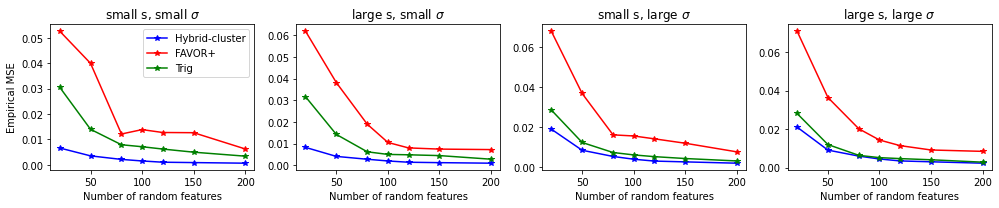

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [ ]:
####again new code
new_dim = 50
n_sample = 1000

np.random.seed(1263)
Q_mu_0 = np.random.uniform(low = -4,high = -3, size= new_dim)
Q_mu_0 = np.multiply(Q_mu_0,2*np.random.randint(0,1)-1)  # randomly change sign 
K_mu_0 = np.random.uniform(low = 2, high = 5, size = new_dim)
K_mu_0 = np.multiply(np.random.randint(2, size=new_dim)*2-1,K_mu_0) # randomly change sign 

np.random.seed(1265)
ortho_group_list_1 = [ortho_group.rvs(dim=new_dim) for i in range(2)] #use orthogonal matrix  to generate different clusters
np.random.seed(1266)
ortho_group_list_2 = [ortho_group.rvs(dim=new_dim) for i in range(2)] #use orthogonal matrix  to generate different clusters


result_all = []
fig = plt.figure(figsize=(14,3))
  
 
w = 0

for sigma_val in [1,10]: #different level of concentration

  for k in [12,25]: ### try transform synthetic data in different fashions


    ####rotate data to get different clusters
    Q_mu_1 = Q_mu_0@ortho_group_list_1[0]
    Q_mu_2 = Q_mu_0@ortho_group_list_1[1]  
    K_mu_1 = K_mu_0@ortho_group_list_1[0]
    K_mu_2 = K_mu_0@ortho_group_list_1[1]  

    ### transform 
    Q_mu_1, K_mu_1 = transform_sign (Q_mu_1, K_mu_1,k) 
    Q_mu_2 = np.abs(Q_mu_2) * np.sign(Q_mu_1) #make both clusters in the same space
    Q_mu_2, K_mu_2 = transform_sign (Q_mu_2, K_mu_2,k)

    np.random.seed(679)

    sigma = sigma_val ## the variane of data


    Q_small_sample_high_dim = np.append(np.random.multivariate_normal(Q_mu_1, sigma*np.identity(new_dim), n_sample),np.random.multivariate_normal(Q_mu_2, sigma*np.identity(new_dim), n_sample),axis = 0)  
    K_small_sample_high_dim = np.append(np.random.multivariate_normal(K_mu_1, sigma*np.identity(new_dim), n_sample),np.random.multivariate_normal(K_mu_2, sigma*np.identity(new_dim), n_sample),axis = 0)  
    #normalize data
    Q_small_sample_high_dim = row_noramlize(Q_small_sample_high_dim,if_l2=1) * 0.1 
    K_small_sample_high_dim = row_noramlize(K_small_sample_high_dim,if_l2=1)  


    #tau_value_list = np.linspace(0.1, 1.0, num = 10)
    tau_value_list = [1]

    nrff_list = [20,50,80,100,120,150,200]

    mse_list_result = []
    n_iters = 20 # the time of repititions

    ##### Plot against nrff

    if_compare_trig = 1 

    for nrff in nrff_list:
      print(nrff)
      mse_list_result_for_fixed_nrff = []
      for i in range(n_iters):
        mse_temp = evaluate_performance(Q_small_sample_high_dim, K_small_sample_high_dim,generate_matrix_using_cluaster(Q_small_sample_high_dim,K_small_sample_high_dim),data_dim = new_dim, if_trig = if_compare_trig
                          ,tau_value_list = tau_value_list
                          ,n_rff = nrff
                          ,random_number = 1234+i) 

        mse_list_result_for_fixed_nrff.append(mse_temp)
      
      mse_cluster_mean = np.mean([mse_list_result_for_fixed_nrff[i]['mse_cluster_list'] for i in range(n_iters)],axis=0)
      mse_favor_plus_mean = np.mean([mse_list_result_for_fixed_nrff[i]['mse_favor_plus'] for i in range(n_iters)],axis=0)
      mse_trig_mean = np.mean([mse_list_result_for_fixed_nrff[i]['mse_trig'] for i in range(n_iters)],axis=0)

      mse_cluster_std = np.std([mse_list_result_for_fixed_nrff[i]['mse_cluster_list'] for i in range(n_iters)],axis=0)
      mse_favor_plus_std = np.std([mse_list_result_for_fixed_nrff[i]['mse_favor_plus'] for i in range(n_iters)],axis=0)
      mse_trig_std = np.std([mse_list_result_for_fixed_nrff[i]['mse_trig'] for i in range(n_iters)],axis=0)


      mse_cluster_max = np.max([mse_list_result_for_fixed_nrff[i]['mse_cluster_list'] for i in range(n_iters)],axis=0)
      mse_favor_plus_max = np.max([mse_list_result_for_fixed_nrff[i]['mse_favor_plus'] for i in range(n_iters)],axis=0)
      mse_trig_max = np.max([mse_list_result_for_fixed_nrff[i]['mse_trig'] for i in range(n_iters)],axis=0)


      mse_cluster_min = np.min([mse_list_result_for_fixed_nrff[i]['mse_cluster_list'] for i in range(n_iters)],axis=0)
      mse_favor_plus_min = np.min([mse_list_result_for_fixed_nrff[i]['mse_favor_plus'] for i in range(n_iters)],axis=0)
      mse_trig_min = np.min([mse_list_result_for_fixed_nrff[i]['mse_trig'] for i in range(n_iters)],axis=0)


      mse_list_result.append({'nrff':nrff,'mse_cluster_mean':mse_cluster_mean, 'mse_favor_plus_mean':mse_favor_plus_mean,"mse_trig_mean":mse_trig_mean
            ,'mse_cluster_std':mse_cluster_std,'mse_favor_plus_std':mse_favor_plus_std,'mse_trig_std':mse_trig_std
            ,'mse_cluster_max':mse_cluster_max,'mse_favor_plus_max':mse_favor_plus_max,'mse_trig_max':mse_trig_max
            ,'mse_cluster_min':mse_cluster_min,'mse_favor_plus_min':mse_favor_plus_min,'mse_trig_min':mse_trig_min} 
             )



    nrff_list_len = len(nrff_list)


    mse_cluster_mean_against_rff = [mse_list_result[i]['mse_cluster_mean'][0] for i in range(nrff_list_len)]   
    mse_favor_plus_against_rff = [mse_list_result[i]['mse_favor_plus_mean'] for i in range(nrff_list_len)]
    mse_trig_against_rff = [mse_list_result[i]['mse_trig_mean'] for i in range(nrff_list_len)]

    mse_cluster_against_rff_min = [mse_list_result[i]['mse_cluster_min'][0] for i in range(nrff_list_len)]   
    mse_favor_plus_against_rff_min = [mse_list_result[i]['mse_favor_plus_min'] for i in range(nrff_list_len)]
    mse_trig_against_rff_min = [mse_list_result[i]['mse_trig_min'] for i in range(nrff_list_len)]


    mse_cluster_against_rff_max = [mse_list_result[i]['mse_cluster_max'][0] for i in range(nrff_list_len)]   
    mse_favor_plus_against_rff_max = [mse_list_result[i]['mse_favor_plus_max'] for i in range(nrff_list_len)]
    mse_trig_against_rff_max = [mse_list_result[i]['mse_trig_max'] for i in range(nrff_list_len)]


    result_new = ({'mse_cluster_against_rff_min':mse_cluster_against_rff_min,
             'mse_favor_plus_against_rff_min':mse_favor_plus_against_rff_min,      
             'mse_trig_against_rff_min':mse_trig_against_rff_min, 
             'mse_cluster_against_rff_max':mse_cluster_against_rff_max,
             'mse_favor_plus_against_rff_max':mse_favor_plus_against_rff_max,      
             'mse_trig_against_rff_max':mse_trig_against_rff_max
                   })


    result_all.append({'result_new':result_new,'sigma':sigma_val,'k':k})



    w = w + 1#index for subplot

    plt.subplot(1, 4, w)
   
    plt.plot(nrff_list,mse_cluster_mean_against_rff,'-*',label='Hybrid-cluster',color='b')
    plt.plot(nrff_list,mse_favor_plus_against_rff,'-*',label='FAVOR+',color='r')
    plt.plot(nrff_list,mse_trig_against_rff,'-*',label='Trig',color='g')

    

    if k != 25:
      str_1 = 'small s, '
    else:
      str_1 = 'large s, '

    if sigma_val != 1:
      str_2 = 'large $\sigma$'
    else:
      str_2 = 'small $\sigma$'


    plt.title(str_1 + str_2  )
    plt.xlabel('Number of random features') 

    if k != 25 and sigma_val == 1:  #to make the plot compact
      plt.legend()
      plt.ylabel('Empirical MSE')
    
     

fig.tight_layout()
plt.show() 
fig.savefig('Cluster_result.eps',format='eps',dpi=600) 
fig.savefig('Cluster_result.png',dpi=1200) 


In [ ]:
### print result as a table form
def combine_text(x,y): ##print [x,y]
  x = ["%.4f" %round(i,4) for i in x]
  y = ["%.4f" %round(i,4) for i in y]
  result = ['['+str(a)+','+str(b)+']' for (a,b) in zip(x,y)]
  return result

def print_3(a,b,c,d): #print 3 in one row
  for i in range(len(a)):
    print(str(d[i])+' '+a[i] + ' ' + b[i] + ' ' + c[i])

for i in range(4):
  a = combine_text(result_all[i]['result_new']['mse_cluster_against_rff_min'], result_all[i]['result_new']['mse_cluster_against_rff_max']) 
  b = combine_text(result_all[i]['result_new']['mse_favor_plus_against_rff_min'], result_all[i]['result_new']['mse_favor_plus_against_rff_max']) 
  c = combine_text(result_all[i]['result_new']['mse_trig_against_rff_min'], result_all[i]['result_new']['mse_trig_against_rff_max']) 
  print_3(a,b,c,nrff_list)
  print('')


20 [0.0016,0.0183] [0.0071,0.1455] [0.0039,0.0808]
50 [0.0011,0.0081] [0.0026,0.2541] [0.0031,0.0510]
80 [0.0005,0.0052] [0.0032,0.0282] [0.0010,0.0281]
100 [0.0006,0.0036] [0.0022,0.0528] [0.0013,0.0170]
120 [0.0004,0.0025] [0.0028,0.0534] [0.0012,0.0135]
150 [0.0003,0.0020] [0.0014,0.0582] [0.0007,0.0134]
200 [0.0002,0.0010] [0.0013,0.0205] [0.0004,0.0087]

20 [0.0032,0.0265] [0.0095,0.2071] [0.0036,0.0989]
50 [0.0012,0.0079] [0.0036,0.2123] [0.0019,0.0565]
80 [0.0007,0.0059] [0.0037,0.0570] [0.0008,0.0208]
100 [0.0007,0.0040] [0.0016,0.0280] [0.0010,0.0164]
120 [0.0005,0.0025] [0.0013,0.0262] [0.0007,0.0246]
150 [0.0004,0.0024] [0.0010,0.0407] [0.0004,0.0190]
200 [0.0003,0.0018] [0.0018,0.0236] [0.0004,0.0134]

20 [0.0083,0.0300] [0.0362,0.1218] [0.0174,0.0490]
50 [0.0046,0.0183] [0.0125,0.1262] [0.0081,0.0249]
80 [0.0029,0.0105] [0.0108,0.0281] [0.0044,0.0143]
100 [0.0024,0.0056] [0.0077,0.0421] [0.0041,0.0095]
120 [0.0020,0.0046] [0.0077,0.0402] [0.0034,0.0077]
150 [0.0015,0.0041]